<a href="https://colab.research.google.com/github/mtsilimos/ETH/blob/main/CV_GOODIDEASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteC52PGR/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteC52PGR/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [29]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpyw2svrt5tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

In [30]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [31]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [32]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [33]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [34]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [35]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [41]:
def display(display_list):
  plt.figure(figsize=(10, 5))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

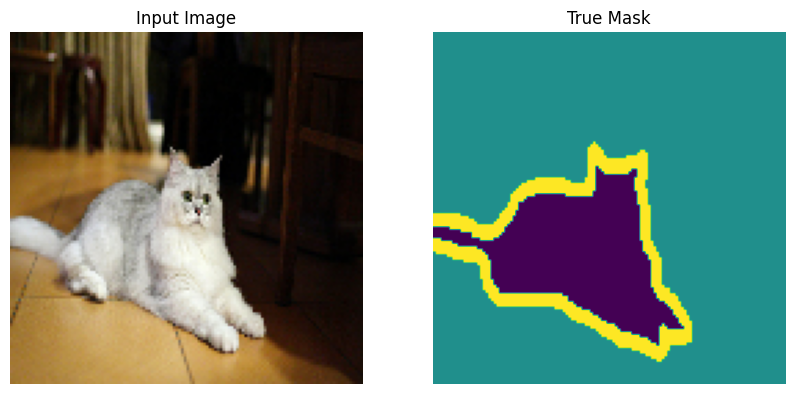

In [45]:
import matplotlib.pyplot as plt

for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [74]:
img_size = (200, 200)
def get_model(img_sizem ,num_classes):
  """
  This function will define the U-net model
  """
  # define the input layer
  input_layer = Input(shape=img_size + (3, ))

  # Rescaling layer
  rescaling = Rescaling(1. / 255)(input_layer) # rescale input images to [0, 1]

  # define convolution layers (Downward)
  x = Conv2D(64, 3, padding="same", activation="relu", strides=2)(rescaling)
  x = Conv2D(64, 3, padding="same", activation="relu")(x)
  x = Conv2D(128, 3, padding="same", activation="relu", strides=2)(x)
  x = Conv2D(128, 3, padding="same", activation="relu")(x)
  x = Conv2D(256, 3, padding="same", activation="relu", strides=2)(x)
  x = Conv2D(256, 3, padding="same", activation="relu")(x)
  x = Dropout(0.01)(x)

  # define Transpose layers (Upward)
  y = Conv2DTranspose(256, 3, padding="same", activation="relu")(x)
  y = Conv2DTranspose(256, 3, padding="same", activation="relu", strides=2)(y)
  y = Conv2DTranspose(128, 3, padding="same", activation="relu")(y)
  y = Conv2DTranspose(128, 3, padding="same", activation="relu", strides=2)(y)
  y = Conv2DTranspose(64, 3, padding="same", activation="relu")(y)
  y = Conv2DTranspose(64, 3, padding="same", activation="relu", strides=2)(y)
  y = Dropout(0.01)(y)

  # define the output layer
  output_layer = Conv2D(num_classes, 3, padding="same", activation="softmax")(y)

  # create the model
  model = Model(input_layer, output_layer)

  return model


In [75]:
model = get_model(img_size, 3)
model.summary()

NameError: ignored

In [19]:
def load_image_train(datapoint):
  #resize to 128x128x3
    input_image = tf.image.resize_with_pad(datapoint['image'], 128, 128)
    input_mask = tf.image.resize_with_pad(datapoint['segmentation_mask'], 128, 128)

    # Randomly flip (simple augmentation)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    # Normalize the pixel values of the input images
    input_image = tf.cast(input_image, tf.float32) / 255.0


    return input_image, input_mask

In [20]:
def load_image_test(datapoint):
    input_image = tf.image.resize_with_pad(datapoint['image'], 128, 128)
    input_mask = tf.image.resize_with_pad(datapoint['segmentation_mask'], 128, 128)


    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image, input_mask

In [21]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [22]:

BATCH_SIZE = 64
BUFFER_SIZE = 1000
# use batch size of 64 and buffer size of 1000 to shuffle the images in train dataset
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

